In [1]:
import math
import numpy as np
from numpy import linalg
from scipy import stats
from scipy import constants as cons
from scipy.stats import linregress
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
# from PIL import Image

In [2]:
# help(plt.ticklabel_format)

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

# plt.rcParams['font.sans-serif']='KaiTi'

F=cons.e*cons.N_A
t2t=273.15

$\lim\limits_{n\rightarrow \infty} ({n+1 \over n})^n$

$P=P_2^\infty ={3\alpha \epsilon _1 \over (\epsilon _1 +2)^2}*{M_1 \over \rho _1}+
{\epsilon _1-1 \over \epsilon _1 +2}*{M_2-\beta M_1 \over \rho}$

$\phi(x)=\int_0^{x^2} xf(t)dt,\phi^{'}(x)=?$

In [4]:
def Array(x,dtype=None):
    return np.array(x,dtype=dtype)

def Like(x):
    return range(len(x))

def vectorize(*args,f):
    return np.vectorize(f)(*args)

def new_vector(arg,shape=None,like=None,pos=None):
    #用nan填充到指定长度vector
    if shape is None: shape=like.shape[0]
    assert shape is not None
    
    if pos is None: pos=shape//2
    re=[np.nan]*pos
    re.append(arg)
    re+=[np.nan]*(shape-pos-1)
    return np.expand_dims(re,axis=0)

def slice_vector(v,slices):
    re=[]
    for i in slices:
        re.append(v[i])
    return np.array(re)

def print_lists(*args,var=locals().items()):
    for lis in args:
        for k,v in var:
            if v is lis:
                print(k,end=' = ')
        print(lis)
        
def form_print(x,format_s=None):
    if format_s is None:
        print(*x,sep='\t')
    else:
        for i in x:
            print(format_s % i,end='')
        print()

In [5]:
def quick_axis_label(xlabel=None,ylabel=None):
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
        
def self_adaptive_axis_range(x=None,y=None,bias_coef=0.01):
    def cal_range(x):
        mi,ma=min(x),max(x)
        R=ma-mi
        bias=R*bias_coef
        return mi-bias,ma+bias
    
    if x is not None:
        plt.xlim(*cal_range(x))
    if y is not None:
        plt.ylim(*cal_range(y))

In [6]:
def show_data_frame(data,index=None,columns=None,formatter=None,subset=None,index_name=None,columns_name=None):
    if not isinstance(data,np.ndarray): data=np.array(data)
    assert len(data.shape) == 2
    if index is None:
        index=range(1,data.shape[0]+1)
    df=pd.DataFrame(data,index=index,columns=columns)
    df.index.name=index_name
    df.columns.name=columns_name
    if formatter: df=df.style.format(formatter,subset=subset)
    return df

def arrange_formatter(*args):
    global columns
    i=1
    re={}
    while (i < len(args)):
        k,v=args[i-1],args[i]
        if type(k) is int:
            re[columns[k]]=v
        elif isinstance(k,(list,range)):
            for index in k:
                re[columns[index]]=v
        i+=2
    print(re)
    return re

def nan_white(df):
    def nan_white_fn(x):
        if np.isnan(x):
            return 'color:white'
        else:
            return 'color:black'
        
    try:
        return df.style.applymap(nan_white_fn)
    except:
        return df.applymap(nan_white_fn)
    
def slice_column(df,idx):
    idx=[df.columns[i] for i in idx]
    return df[idx]

def br(s,step=15):
    ls=list(s)
    i=1
    while i*step-1 < len(s):
        ls.insert(i*step-1,'<br>')
        i+=1
    return ''.join(ls)

def at(df,i):
    return np.array(df[df.columns[i]])

In [42]:
def show_regress(x,y,degree=1,force=False,
                 scatter=True,clip_on=False,
                 extend_to_axis=False,extend=None,
                 xlabel=None,ylabel=None,plot_label=None,
                 xlim=None,ylim=None,
                 verbose=1,show=True):
    '''
    拟合数据x,y并且绘制所拟合曲线
    degree为多项式次数，默认为1
    可选参数：
    xlabel,ylabel为坐标轴标签，plot_label为曲线标签
    scatter为True（默认）时绘制原始x,y散点,clip_on传入scatter
    xlim和ylim支持快捷格式'min','max','minmax'，以及如同plt.xlim((left,right))原始参数
    extend_to_axis为True则将曲线绘制到x与y轴的截距，extend为自由增加x取值
    '''
    
    def set_axis_range(feature,limit=None,**kwargs):
        import logging
        def check_format_str(s):
            words=['min','max','minmax']
            if isinstance(s,str) and s in words:
                return True
            else:
                logging.warning(f"str only support for {words},but received {s}")
                return False
            
        if feature not in ['x','y']:
            raise ValueError
        fn_dict={'x':(plt.xlim,x), 'y':(plt.ylim,y)}
        fn,var=fn_dict[feature]
        if isinstance(limit,tuple):
            fn(limit)
        elif isinstance(limit,str):
            if check_format_str(limit) is False:
                return
            elif limit == 'min':
                fn((min(var),None))
            elif limit == 'max':
                fn((None,max(var)))
            elif limit == 'minmax':
                fn((min(var),max(var)))
    
    global reg
    #线性回归且非强制多项式
    if degree == 1 and not force:
        #线性回归输出参数以及回归方程和拟合优度
        reg=linregress(x,y)
        if verbose > 0:
            print(reg)
            if verbose > 1:
                print('y={:.3e}x {:+.3e}'.format(reg.slope,reg.intercept),end=' \t')
            print("R^2=%.5f" % np.square(reg.rvalue))
    else:
        #多项式回归输出多项式系数
        reg=np.polyfit(x,y,degree)
        print(reg)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if scatter: plt.scatter(x,y,clip_on=clip_on)

    if extend_to_axis:
        x=np.append(x,[0])
        plt.xlim(left=0)
    if extend:
        x=np.append(x,[extend])
        
    #产生回归y值
    if degree == 1 and not force:
        predict=[i*reg.slope+reg.intercept for i in x]
    else:
        predict=[np.polyval(reg,i) for i in x]
    #绘制
    if xlim is not None:
        set_axis_range('x',xlim)
    if ylim is not None:
        set_axis_range('y',ylim)
                
    plt.plot(x,predict,label=plot_label,linewidth=4)
    if show:
        plt.show()
    
def from_standard_curve(y,print_fn=False):
    global reg
    if print_fn:
        for i in y:
            print((i-reg.intercept)/reg.slope)
    else:
        return (y-reg.intercept)/reg.slope

LinregressResult(slope=1.0, intercept=0.0, rvalue=1.0, pvalue=0.0, stderr=0.0)
R^2=1.00000


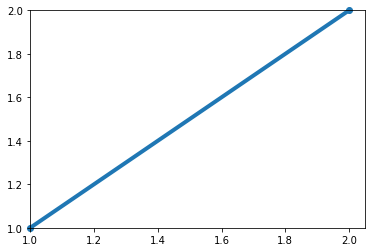

In [44]:
show_regress([1,2],[1,2],xlim=(1,None),ylim='minmax')

In [8]:
def adj_f(t0,asst,h0):
    h=(t0-h0)
    dt=(t0-asst)
    return t0+1.56e-4*h*dt

def new_c(volume,c0,total_V):
    return c0*volume/total_V

def time_change(expr):
    m,sec=expr//100,expr%100
    assert sec <= 60
    return m*60+sec

In [9]:
def relative_error(pi,p0):
    return abs(pi-p0)/p0*100

def Q_check(data,idx,alpha=0.1):
    Q_table={0.1:[0,0,0,0.94,0.76,0.64,0.56,0.51,0.47,0.44,0.41],
             0.05:[0,0,0,0.97,0.84,0.73,0.64,0.59,0.54,0.51,0.49]}
    upper,lower=np.max(data),np.min(data)
    n=len(data)
    if data[idx] == upper:
        near=np.max(np.delete(data,idx))
    else:
        near=np.min(np.delete(data,idx))
    Q=abs((data[idx]-near)/(upper-lower))
    Q_lim=Q_table[alpha][n]
    print(f'n={n}, Q={Q}, limits={Q_lim}')
    return Q > Q_lim

def cal_Cronbache_alpha(k,var):
    return (k/(k-1))*(var[-1]-sum(var[:-1]))/var[-1]

In [10]:
def t_interval(x,alpha=0.8):
    n=len(x)-1
    avg=np.mean(x)
    std=np.std(x,ddof=1)
    interval=np.array(stats.t.interval(alpha,n))
    re=avg+std/np.sqrt(n)*interval
    print('{:.4f}+/-{:.4f}'.format(avg,re[1]-avg))
    return re

In [13]:
Hg=13.6*1e3
g=9.8
p0=1.013e4

In [29]:
np.sqrt(344.7*71.4)

156.88078276194315

In [32]:
1.858e-27*(313**1.5)/1/(3.569**2*1e-20)/1.075*np.sqrt(1/28+1/36.5)

1.8876221516200714e-05

In [33]:
r1=10.65e-2
r2=17.65e-2
rho=900
rho*(4)/Hg

0.2647058823529412

In [30]:
V=Array([429,425,420])/1e2
m=0.13
n=Array(m)/(46+1+32+64+12*18)
n*1e3

0.362116991643454

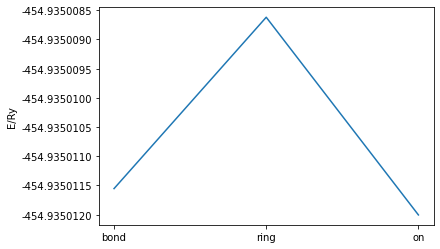

In [29]:
def formatter(x,pos):
    return '%.7f' % x
f=plt.FuncFormatter(formatter)
plt.gca().yaxis.set_major_formatter(f)

plt.ylabel('E/Ry')
plt.plot(['bond','ring','on'],[-454.9350115539,-454.9350086193,-454.9350120047])

In [58]:
c=10.36/329.9/12
c
c1=2.5/270
c1
3/(39+35.5)

0.0026169546327169846

0.009259259259259259

0.040268456375838924

In [70]:
4e-4*0.1*3461

0.13844

In [79]:
help(np.random.normal)

Help on built-in function normal:

normal(...) method of numpy.random.mtrand.RandomState instance
    normal(loc=0.0, scale=1.0, size=None)
    
    Draw random samples from a normal (Gaussian) distribution.
    
    The probability density function of the normal distribution, first
    derived by De Moivre and 200 years later by both Gauss and Laplace
    independently [2]_, is often called the bell curve because of
    its characteristic shape (see the example below).
    
    The normal distributions occurs often in nature.  For example, it
    describes the commonly occurring distribution of samples influenced
    by a large number of tiny, random disturbances, each with its own
    unique distribution [2]_.
    
    .. note::
        New code should use the ``normal`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    loc : float or array_like of floats
        Mean ("centre") of the distribution

In [171]:
A4=Array([58,55,52,51,49,46,44])/1e3+0.1
A6=Array([56,52,49,46,44,41,39])/1e3+0.1
A8=(A4-0.032)*2**1.5-0.2+np.random.normal(0,0.001,size=(7))
A12=Array([151,138,127,116,106,98,89])/1e3
form_print(A4,format_s='%.3f\t')
form_print(A6,format_s='%.3f\t')
form_print(A8,format_s='%.3f\t')
form_print(A12,format_s='%.3f\t')

In [175]:
for i in [A4,A6,A8,A12]:
    form_print(i,format_s='%.3f\t')
    form_print(-np.log(i-0.032),format_s='%.3f\t')

0.158	0.155	0.152	0.151	0.149	0.146	0.144	
2.071	2.096	2.120	2.129	2.146	2.172	2.189	
0.156	0.152	0.149	0.146	0.144	0.141	0.139	
2.087	2.120	2.146	2.172	2.189	2.216	2.235	
0.157	0.147	0.140	0.135	0.131	0.120	0.117	
2.076	2.161	2.225	2.271	2.309	2.428	2.466	
0.151	0.138	0.127	0.116	0.106	0.098	0.089	
2.129	2.244	2.354	2.477	2.604	2.718	2.865	


In [182]:
form_print(Array(k)*1e3,format_s='%.3f*10^-3\t')

2.707*10^-3	3.461*10^-3	8.830*10^-3	17.375*10^-3	


LinregressResult(slope=0.002707340453618795, intercept=2.0749078790697397, rvalue=0.9945558351846365, pvalue=4.188072546479696e-06, stderr=0.00012685787495148422, intercept_stderr=0.0032017480098378267)
R^2=0.98914
LinregressResult(slope=0.0034608213165196796, intercept=2.093817848540155, rvalue=0.9968483495400372, pvalue=1.0692156393546418e-06, stderr=0.00012317048320868308, intercept_stderr=0.003108682449828082)
R^2=0.99371
LinregressResult(slope=0.008829622934555675, intercept=2.0894466355801895, rvalue=0.9924069253259085, pvalue=9.610127223717261e-06, stderr=0.0004894014209550593, intercept_stderr=0.01235193342276882)
R^2=0.98487
LinregressResult(slope=0.01737549580815609, intercept=2.1194373840490597, rvalue=0.9993217742279061, pvalue=2.3000207225167077e-08, stderr=0.0002863355991073853, intercept_stderr=0.007226783792006651)
R^2=0.99864


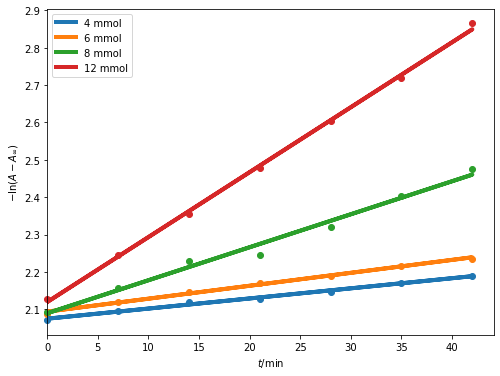

In [165]:
k=[]
fig=plt.gcf()
fig.set_size_inches((8,6))
x=np.linspace(0,42,7)
data=[-np.log(A-0.032) for A in [A4,A6,A8,A12]]
for y in data:
    show_regress(x,y,show=False,extend_to_axis=True)
    k.append(reg.slope)
quick_axis_label('$t$/min','$-$ln($A-A_\infty$)')
plt.legend(["%d mmol"%i for i in [4,6,8,12]])

LinregressResult(slope=1.7925492275667492, intercept=3.822738405625689, rvalue=0.9675778464121253, pvalue=0.0324221535878747, stderr=0.330869754029598, intercept_stderr=1.6504908579432946)
y=1.793e+00x +3.823e+00 	R^2=0.93621


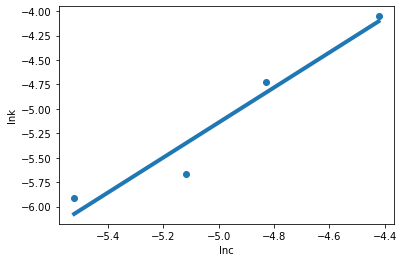

In [183]:
c=Array([4,6,8,12])*1e-3
show_regress(np.log(c),np.log(k),show=0,verbose=2)
quick_axis_label('lnc','lnk')

In [191]:
t=np.linspace(0,25,6,dtype=np.int32)
a1=Array([232,225,222,220,218,214])/1000
a2=Array([192,186,181,176,171,167])/1e3
a3=Array([201,190,181,173,166,158])/1e3
a4=Array([225,210,197,186,177,169])/1e3

LinregressResult(slope=-0.0006457142857142864, intercept=0.22990476190476192, rvalue=-0.9726091908384733, pvalue=0.0011151095744842097, stderr=7.716049181153933e-05, intercept_stderr=0.0011680749517777181)
R^2=0.94597
LinregressResult(slope=-0.0009999999999999998, intercept=0.1913333333333333, rvalue=-0.9984796646472148, pvalue=3.4653723109375876e-06, stderr=2.7602622373693365e-05, intercept_stderr=0.0004178554470186603)
R^2=0.99696
LinregressResult(slope=-0.001685714285714286, intercept=0.19923809523809527, rvalue=-0.9969497593608393, pvalue=1.3941762264597662e-05, stderr=6.59828879073861e-05, intercept_stderr=0.0009988655696858632)
R^2=0.99391
LinregressResult(slope=-0.0022285714285714287, intercept=0.2218571428571429, rvalue=-0.9929097879623161, pvalue=7.522844370590097e-05, stderr=0.00013340134319918595, intercept_stderr=0.0020194631198704816)
R^2=0.98587


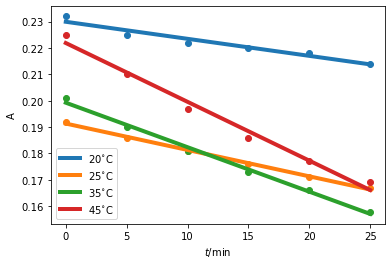

In [199]:
k=[]
for i in [a1,a2,a3,a4]:
    show_regress(t,i,show=False)
    k.append(reg.slope)
plt.legend(['%d$^{\circ}$C'%i for i in [20,25,35,45]])
quick_axis_label('$t$/min','A')

LinregressResult(slope=-4549.421622708924, intercept=8.274082157395387, rvalue=-0.9815216065862661, pvalue=0.01847839341373391, stderr=627.1520352603155, intercept_stderr=2.063333566268747)
y=-4.549e+03x +8.274e+00 	R^2=0.96338


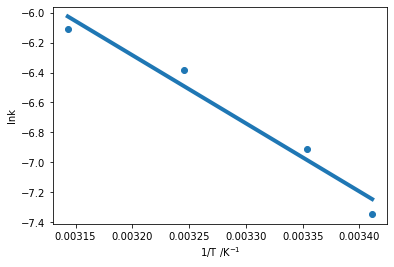

In [211]:
T=1/(Array([20,25,35,45])+273.15)
show_regress(T,np.log(np.abs(k)),show=False,verbose=2)
quick_axis_label(r'1/T /$\mathrm{K^{-1}}$','lnk')

In [213]:
data=Array([[99,88,79,71,65],
      [119,107,98,89,83],
      [132,117,105,97,91],
      [153,135,124,116,114]])/1e3

In [214]:
# data=np.stack([a1,a2,a3,a4],axis=0)
index=columns=None
index=[4,6,8,12]
columns=[0,6,12,19,27]
formatter=None
# formatter=arrange_formatter(range(5),'{:.4f}')
subset=None
# subset=pd.IndexSlice[index[:4],columns]


d2=show_data_frame(data,index,columns,formatter,subset,columns_name='')
# d2=d2.format('{:.0f}',subset=pd.IndexSlice[index[:1],columns])
# df=df.format('{:.4f}',subset=pd.IndexSlice[index[5:],columns[:1]])
d2

,0,6,12,19,27
4,0.099,0.088,0.079,0.071,0.065
6,0.119,0.107,0.098,0.089,0.083
8,0.132,0.117,0.105,0.097,0.091
12,0.153,0.135,0.124,0.116,0.114


Text(0, 0.5, 'Scores')

[Text(0, 0, 'G1'), Text(1, 0, 'G2'), Text(2, 0, 'G3'), Text(3, 0, 'G4')]

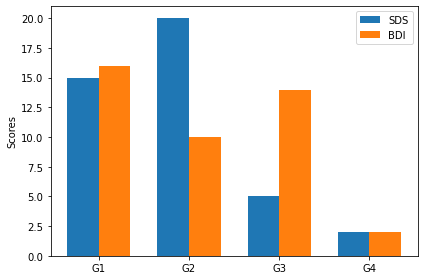

In [18]:
labels = ['G1', 'G2', 'G3', 'G4',]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, SDS_n, width, label='SDS')
rects2 = ax.bar(x + width/2, BDI_n, width, label='BDI')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

(0.00035467154811715494, 0.015)

(3, 9)

Text(0.5, 0, 'v')

Text(0, 0.5, 'p/MPa')

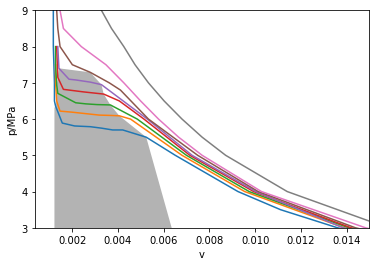

In [22]:
ax=plt.subplot(1,1,1)
for i in range(len(h)):
    temp=ax.plot(h[i],p[i])
poly=plt.Polygon(data,facecolor='0.7')
ax.add_patch(poly)
plt.xlim(right=1.5e-2)
plt.ylim([3,9])
plt.xlabel('v')
plt.ylabel('p/MPa')

In [28]:
help(scipy.optimize.curve_fit)

Help on function curve_fit in module scipy.optimize.minpack:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
    Use non-linear least squares to fit a function, f, to data.
    
    Assumes ``ydata = f(xdata, *params) + eps``
    
    Parameters
    ----------
    f : callable
        The model function, f(x, ...).  It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : array_like or object
        The independent variable where the data is measured.
        Should usually be an M-length sequence or an (k,M)-shaped array for
        functions with k predictors, but can actually be any object.
    ydata : array_like
        The dependent data, a length M array - nominally ``f(xdata, ...)``.
    p0 : array_like, optional
        Initial guess for the parameters (length N).  If None, then the
        init

In [11]:

def func(indep_vars,A,B,C):
    T=indep_vars
    
    return A-B/(T+C)

#以水的饱和蒸气压为例
t=np.array([0,10,20,30,40,50,60,70])
p=np.array([610,1228,2338,4242,7375,12333,19910,31157])

lgp=np.log10(p*(760/101e3))#转化为mmHg并取对数

var,co=optimize.curve_fit(func,xdata=t,ydata=lgp, maxfev=9999)
print(var)
pred=func(t,*var)
real=func(t,8.07,1730,233) #文献值

[   8.12032223 1757.50243945  235.63950216]
